# Thrasio Spotify Music Classification

## Importing the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import seaborn as sns
import warnings
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import plot_confusion_matrix
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv(r'music_genre.csv')
df.head()

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic


## Exploring the data

In [3]:
df.describe(include='all')

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
count,50000.000000,50000,50000,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,50000,50000.000000,50000.000000,50000,50000.000000,50000,50000,50000.000000,50000
unique,NaN,6863,41699,NaN,NaN,NaN,NaN,NaN,NaN,12,NaN,NaN,2,NaN,29394,5,NaN,10
top,NaN,empty_field,Home,NaN,NaN,NaN,NaN,NaN,NaN,G,NaN,NaN,Major,NaN,?,4-Apr,NaN,Electronic
freq,NaN,2489,16,NaN,NaN,NaN,NaN,NaN,NaN,5727,NaN,NaN,32099,NaN,4980,44748,NaN,5000
mean,55888.396360,NaN,NaN,44.220420,0.306383,0.558241,2.212526e+05,0.599755,0.181601,NaN,0.193896,-9.133761,NaN,0.093586,NaN,NaN,0.456264,NaN
std,20725.256253,NaN,NaN,15.542008,0.341340,0.178632,1.286720e+05,0.264559,0.325409,NaN,0.161637,6.162990,NaN,0.101373,NaN,NaN,0.247119,NaN
min,20002.000000,NaN,NaN,0.000000,0.000000,0.059600,-1.000000e+00,0.000792,0.000000,NaN,0.009670,-47.046000,NaN,0.022300,NaN,NaN,0.000000,NaN
25%,37973.500000,NaN,NaN,34.000000,0.020000,0.442000,1.748000e+05,0.433000,0.000000,NaN,0.096900,-10.860000,NaN,0.036100,NaN,NaN,0.257000,NaN
50%,55913.500000,NaN,NaN,45.000000,0.144000,0.568000,2.192810e+05,0.643000,0.000158,NaN,0.126000,-7.276500,NaN,0.048900,NaN,NaN,0.448000,NaN
75%,73863.250000,NaN,NaN,56.000000,0.552000,0.687000,2.686122e+05,0.815000,0.155000,NaN,0.244000,-5.173000,NaN,0.098525,NaN,NaN,0.648000,NaN


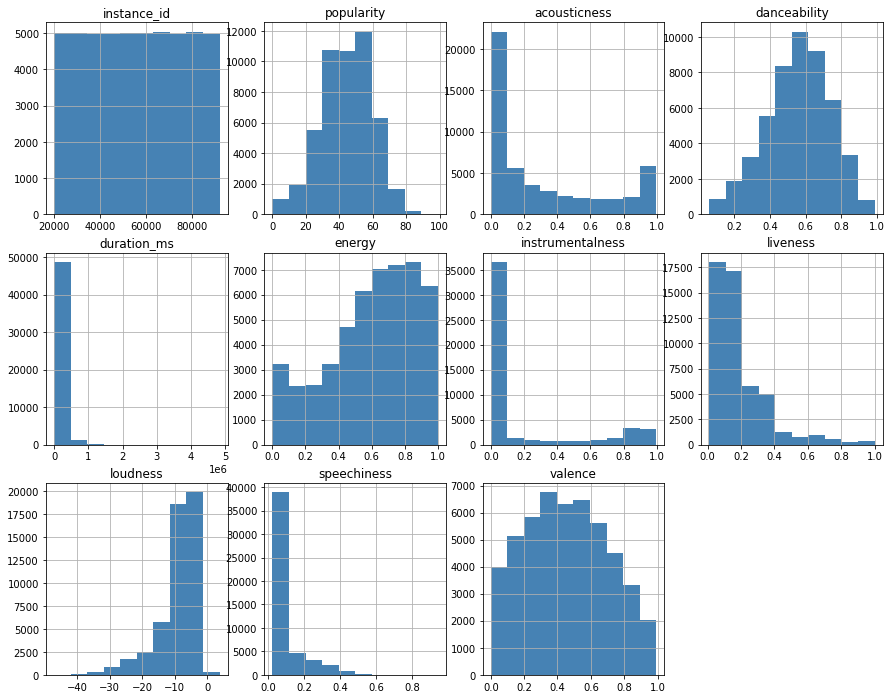

In [4]:
# see the distribution of each quantitative variable
plt.figure(figsize=(15, 12))
for i, col in enumerate([column for column in df.columns if df[column].dtype != 'object']):
    plt.subplot(3, 4, i + 1)
    df[col].hist(color='steelblue')
    plt.title(f'{col}')
plt.show()

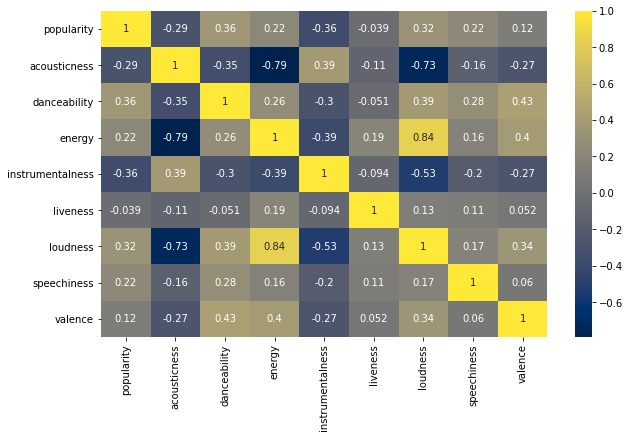

In [5]:
# correlation heatmap
corr = df.drop(columns=['instance_id', 'duration_ms']).corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr, cmap='cividis', annot=True)
plt.show()

## Feature Engineering

In [6]:
# 5 rows of all na, so it's safe to drop all
display(df[df.isna().any(axis=1)])
df = df.dropna().reset_index(drop=True)

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df['instance_id'] = df['instance_id'].astype(int)
df['artist_name'] = df['artist_name'].replace('empty_field', np.nan)
df['popularity'] = df['popularity'] / 10 ** 2  # scale to fit between 0 and 1, similar to the other variables

In [8]:
# number of songs with recorded duration is large enough to drop rows without duration, denoted as '-1'
print('Rows after removing duration_ms NaN:', df[df['duration_ms'] > 0].count()[0])
df = df[df['duration_ms'] > 0]

Rows after removing duration_ms NaN: 45061


In [9]:
# number of songs with recorded tempo is large enough to drop rows without tempo, denoted as '?'
print('Rows after removing tempo NaN:', df[df['tempo'] != '?'].count()[0])
df = df[df['tempo'] != '?']
df['tempo'] = df['tempo'].astype(float).apply(lambda x: round(x, 3))

Rows after removing tempo NaN: 40560


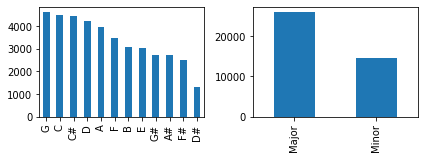

In [10]:
plt.subplot(2, 2, 1)
df['key'].value_counts().plot.bar()
plt.subplot(2, 2, 2)
df['mode'].value_counts().plot.bar()
plt.tight_layout()
plt.show()

In [11]:
df.head()

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
1,46652,Thievery Corporation,The Shining Path,0.31,0.01270,0.622,218293.0,0.890,0.950000,D,0.124,-7.043,Minor,0.0300,115.002,4-Apr,0.531,Electronic
2,30097,Dillon Francis,Hurricane,0.28,0.00306,0.620,215613.0,0.755,0.011800,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177,Dubloadz,Nitro,0.34,0.02540,0.774,166875.0,0.700,0.002530,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907,What So Not,Divide & Conquer,0.32,0.00465,0.638,222369.0,0.587,0.909000,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic
6,43760,Jordan Comolli,Clash,0.46,0.02890,0.572,214408.0,0.803,0.000008,B,0.106,-4.294,Major,0.3510,149.995,4-Apr,0.230,Electronic


## ML Modelling

2 different model scenarios were tested:
* Predicting all 10 individual genres
* Predicting electronic vs. non-electronic genres

## Predicting all Genres

In [12]:
all_genre_df = df.copy()
display(all_genre_df['music_genre'].value_counts())

# create dummy variables for key and mode, and drop unneeded columns
X = pd.get_dummies(all_genre_df, columns=['key', 'mode']).drop(columns=['instance_id', 'artist_name', 'track_name', 'obtained_date', 'music_genre'])
y = all_genre_df['music_genre']
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Rock           4099
Hip-Hop        4077
Anime          4064
Jazz           4064
Alternative    4051
Country        4049
Blues          4046
Rap            4042
Classical      4036
Electronic     4032
Name: music_genre, dtype: int64

(40560, 25)


### Multinomial Logistic Regression - All Genres

In [13]:
LRC = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
LRC.fit(X_train, y_train)

# cross-validation using stratified k-folds does not perform significantly different than simply scoring the test data
all_genre_LRC_score = LRC.score(X_test, y_test)
print(f'Score: {all_genre_LRC_score}')

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
n_scores = cross_val_score(LRC, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)
print(f'Cross-Val Mean Accuracy: {np.mean(n_scores)}')

Score: 0.14102564102564102
Cross-Val Mean Accuracy: 0.1277449046679816


### Random Forest - All Genres

In [14]:
forest = RandomForestClassifier(n_estimators=300, random_state=42)
forest.fit(X_train, y_train)

# same as with logistic regression, cross-validation does not perform significantly different than simply scoring the test data
all_genre_forest_score = forest.score(X_test, y_test)
print(f'Score: {all_genre_forest_score}')

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
n_scores = cross_val_score(forest, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)
print(f'Cross-Val Mean Accuracy: {np.mean(n_scores)}')

Score: 0.5567061143984221
Cross-Val Mean Accuracy: 0.5654832347140039


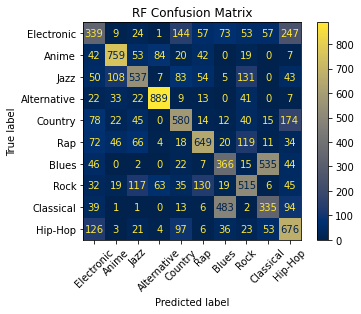

In [15]:
plot_confusion_matrix(
    forest,
    X_test,
    y_test,
    display_labels=y.unique(),
    cmap='cividis'
)
plt.title('RF Confusion Matrix')
plt.grid(False)
plt.xticks(rotation=45)
plt.show()

# Results - All Genres

In [16]:
# Logistic Regression perform inadequately compared to Random Forest when predicting all genres
print(f'Logistic Regression Accuracy: {all_genre_LRC_score * 100:.4f}')
print(f'Random Forest Accuracy: {all_genre_forest_score * 100:.4f}')

Logistic Regression Accuracy: 14.1026
Random Forest Accuracy: 55.6706


## Predicting Electronic Only

Since predicting all 10 individual genres didn't result in desired model accuracy, check if predicting a single genre improves the model

In [17]:
elec_df = df.copy()
elec_df['music_genre'] = elec_df['music_genre'].apply(lambda x: 'Not Electronic' if x != 'Electronic' else x)
display(elec_df['music_genre'].value_counts())

X = pd.get_dummies(elec_df, columns=['key', 'mode']).drop(columns=['instance_id', 'artist_name', 'track_name', 'obtained_date', 'music_genre'])
y = elec_df['music_genre']
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Not Electronic    36528
Electronic         4032
Name: music_genre, dtype: int64

(40560, 25)


In [18]:
# Synthetic minority over-sampling technique used to balance the data
x_smote, y_smote = SMOTE().fit_resample(X_train, y_train)

print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({'Not Electronic': 27427, 'Electronic': 2993})
Resample dataset shape Counter({'Not Electronic': 27427, 'Electronic': 27427})


### Logistic Regression - Electronic Only

In [19]:
LRC = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
LRC.fit(X_train, y_train)  # highest accuracy/correct predictions are achieved with an imbalanced class

# cross-validation using stratified k-folds performs significantly better than simply scoring the test data
electronic_LRC_score = LRC.score(X_test, y_test)
print('Score:', electronic_LRC_score)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
n_scores = cross_val_score(LRC, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)
if np.mean(n_scores) > electronic_LRC_score:
    electronic_LRC_score = np.mean(n_scores)
print(f'Cross-Val Mean Accuracy: {np.mean(n_scores)}')

Score: 0.897534516765286
Cross-Val Mean Accuracy: 0.8976660092044709


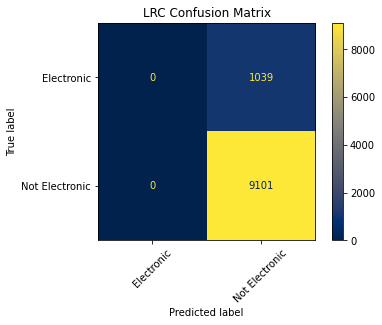

In [20]:
# Even with dataset balancing through over-sampling and under-sampling, the logistic regression model is bad at predicting 
# both electric and non-electric music at the same time, but can predict not-electronic music well
plot_confusion_matrix(
    LRC,
    X_test,
    y_test,
    display_labels=y.unique(),
    cmap='cividis'
)
plt.title('LRC Confusion Matrix')
plt.grid(False)
plt.xticks(rotation=45)
plt.show()

### Random Forest - Electronic Only

In [21]:
forest = RandomForestClassifier(n_estimators=300, random_state=42)
forest.fit(x_smote, y_smote)

# different from logistic regression, cross-validation does not perform significantly different than simply scoring the test data
electronic_forest_score = forest.score(X_test, y_test)
print(f'Score: {electronic_forest_score}')

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
n_scores = cross_val_score(forest, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)
print(f'Cross-Val Mean Accuracy: {np.mean(n_scores)}')

Score: 0.9251479289940828
Cross-Val Mean Accuracy: 0.9276462853385931


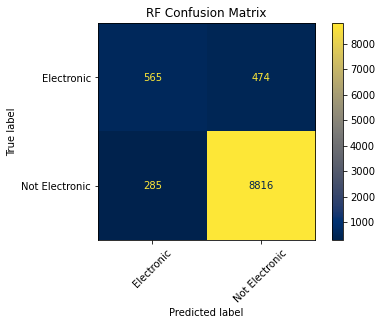

In [22]:
# using SMOTE allows for marginally better classification of electronic music
plot_confusion_matrix(
    forest,
    X_test,
    y_test,
    display_labels=y.unique(),
    cmap='cividis'
)
plt.title('RF Confusion Matrix')
plt.grid(False)
plt.xticks(rotation=45)
plt.show()

# Results - Electronic Only

In [23]:
print(f'Logistic Regression Accuracy: {electronic_LRC_score * 100:.4f}')
print(f'Random Forest Accuracy: {electronic_forest_score * 100:.4f}')

Logistic Regression Accuracy: 89.7666
Random Forest Accuracy: 92.5148


# Explaination and Summary

When trying to predict both individual genres and electronic vs. non-electronic genres, the RandomForestClassifier performed significantly better than Multinomial-LogisticRegression. The respective accuracies were (\~55%, \~93%) and (\~14%, \~90%) for RFC and LR. 

I believe that the large number of genres in the original dataset have an adverse effect on the prediction power of either model. The RFC was good at classifying strictly non-electronic music, but drilling down to any specific genre(s) reduced the accuracy. For example - predicting only 'Anime' and 'Jazz' yielded high model accuracy, but introducing additional genres (testing 'Anime', 'Jazz', 'Rock', ...) lowered the accuracy. The low number of variables could have also contributed to the low model accuracies, as the results suggest that loudness, acousticness, etc, are not exclusive to any one genre. 

Proposed solutions to this are more expensive models like Neural Networks or pricier hyper-parameters, or more comprehensive data collection. NLP could also be utilized, as it would make sense that certain genres contain similar song names by similar artists.

Depending on the business circumstance, I am confident that the models provided are sufficient to predict music genres based off the Spotify stats